# MIP Modeling

MIP is a very powerful modeling framework, allowing you to model a wide variety of problems. In this section we will demonstrate

1. Encoding Boolean logic in a MIP formulation
  - AND, OR, XOR
  - Modeling Sudoku
2. Using Big-Ms for on-off continuous decisions
3. Modeling piecewise constant/linear functions
4. Unions of polyhedras

In [101]:
using JuMP, Gurobi, Interact, Gadfly, Compose

## Logical Constraints (Boolean logic)

There is a natural mapping to Boolean logics `TRUE` and `FALSE` to the binary variables `1` and `0`.  It is also quite common to want to express logical constraints and implications, e.g. "if this factory is built, we can build no other factories in this year", or "either factory A or factory B can be built, but not both". The "trick" is expressing these logical constraints and implications as **linear inequalities**, and sometimes we need to introduce **auxiliary variables**.

We'll start with modeling simple logical statements - `AND` & `OR`.

### AND

"`z` is TRUE if and only if `x` and `y` are both TRUE" (``z = x AND y``)

* `0 AND 0 = 0`
* `1 AND 0 = 0`
* `0 AND 1 = 0`
* `1 AND 1 = 1`

We can write this as
$$z \geq x + y - 1  ,\quad  z \leq x  ,\quad  z \leq y,\quad 0 \leq z \leq 1$$
which we can check by putting the values in (blackboard).

### OR

"`z` is TRUE if and only if either `x` or `y` or both are TRUE" (``z = x OR y``)

* `0 OR 0 = 0`
* `1 OR 0 = 1`
* `0 OR 1 = 1`
* `1 OR 1 = 1`

This can also be expressed by linear inequalities, with no auxiliaries required:
$$z \geq x  ,\quad  z \geq y  ,\quad  z \leq x + y,\quad 0 \leq z \leq 1$$


### XOR

This one is a bit trickier: "`z` is TRUE if and only if either `x` or `y` is TRUE, but not both" (``z = x XOR y``)

* `0 XOR 0 = 0`
* `1 XOR 0 = 1`
* `0 XOR 1 = 1`
* `1 XOR 1 = 0`

One way to do it is `z = x XOR y = (x OR y) - (x AND y)`, but then would need two auxiliary variables, e.g. `z1 = x OR y`, `z2 = x AND y`, and then finally `z = z1 - z2`. Now its your turn:

### EXERCISE: 

### Express `z = x XOR y` with using ONE auxiliary variable. Can you do it with NO auxiliary variables?

## Sudoku

![Sudoku](http://upload.wikimedia.org/wikipedia/commons/f/ff/Sudoku-by-L2G-20050714.svg)

**Sudoku** is a number puzzle played on a 9x9 grid. The challenge is to place a digit between 1 and 9 inclusive in each empty cell, such that the completed grid obeys the following rules:

* Each row contains the numbers 1 to 9 once and only once.
* Each column contains the numbers 1 to 9 once and only once.
* Each 3x3 subgrid contains the numbers 1 to 9 once and only once.

The most natural formulation of this problem would probably be something like

$$x_{i,j} \in \{1, 2, \dots, 9\}$$

which is of course something we can do with integer programming:

$$1 \leq x_{i,j} \leq 9, ~ integer$$

The challenge now is the constraints. One observation is that the numbers 1 to 9 add up to 45, so we could try something like:

$$ \sum_{j=1}^9 x_{i,j} = 45 $$

In [103]:
init_vals = [
5 3 0 0 7 0 0 0 0
6 0 0 1 9 5 0 0 0
0 9 8 0 0 0 0 6 0
8 0 0 0 6 0 0 0 3
4 0 0 8 0 3 0 0 1
7 0 0 0 2 0 0 0 6
0 6 0 0 0 0 2 8 0
0 0 0 4 1 9 0 0 5
0 0 0 0 8 0 0 7 9
]

function sudoku1()
    sudoku = Model(solver=GurobiSolver(OutputFlag=0))
    @defVar(sudoku, 1 ≤ x[1:9,1:9] ≤ 9, Int)
    
    @addConstraints(sudoku, begin
        rows[i=1:9], sum(x[i,:]) == 45
        cols[j=1:9], sum(x[:,j]) == 45
        subgrid[i=1:3:7,j=1:3:7], sum(x[i:i+2,j:j+2]) == 45
    end)
    
    for i in 1:9, j in 1:9
        if init_vals[i,j] != 0
            @addConstraint(sudoku, x[i,j] == init_vals[i,j])
        end
    end
    
    solve(sudoku)
    
    println(getValue(x))
end
sudoku1()

[5.0 3.0 4.0 9.0 7.0 5.0 3.0 2.0 7.0
 6.0 5.0 1.0 1.0 9.0 5.0 4.0 6.0 8.0
 4.0 9.0 8.0 3.0 1.0 5.0 8.0 6.0 1.0
 8.0 1.0 9.0 1.0 6.0 9.0 2.0 6.0 3.0
 4.0 1.0 6.0 8.0 5.0 3.0 9.0 8.0 1.0
 7.0 3.0 6.0 9.0 2.0 2.0 9.0 1.0 6.0
 3.0 6.0 1.0 8.0 6.0 6.0 2.0 8.0 5.0
 3.0 9.0 8.0 4.0 1.0 9.0 5.0 1.0 5.0
 5.0 8.0 2.0 2.0 8.0 1.0 3.0 7.0 9.0]


Well that didn't work. Let's change our **variables**: $x_{i,j,k} = 1$ iff the number $k$ will appear in cell $(i,j)$. We can now use our 0-1 integer programming knowledge to model the problem. Consider the "row" constraints: we want each number to appear once and only once. This is equivalent to saying that

$$\sum_{j=1}^9 x_{i,j,k} = 1 \quad \forall i, k$$

We can now model this as a $9\times 9\times 9$ dimensional problem - thats a lot of binary variables, surely Gurobi won't like that!

In [104]:
function sudoku2()
    sudoku = Model(solver=GurobiSolver())

    @defVar(sudoku, x[i=1:9, j=1:9, k=1:9], Bin)

    @addConstraints(sudoku, begin
        # Constraint 1 - Exactly one value appears in each cell
        cell[i=1:9, j=1:9], sum(x[i,j,:]) == 1
        # Constraint 2 - Each value appears in each row exactly once
        row[i=1:9, k=1:9], sum(x[i,:,k]) == 1
        # Constraint 3 - Each value appears in each column exactly once
        col[j=1:9, k=1:9], sum(x[:,j,k]) == 1
        # Constraint 4 - Each value appears in each 3x3 subgrid exactly once
        subgrid[i=1:3:7,j=1:3:7,val=1:9], sum(x[i:i+2,j:j+2,val]) == 1
    end)

    # Initial solution
    for row in 1:9, col in 1:9
        if init_vals[row,col] != 0
            @addConstraint(sudoku, x[row, col, init_vals[row, col]] == 1)
        end
    end
    
    solve(sudoku)
    
    getValue(x)
end
sudoku2()

Optimize a model with 354 rows, 729 columns and 2946 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [0e+00, 0e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 1e+00]
Presolve removed 354 rows and 729 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0%


9x9x9 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.

Can you see the lines
```
Optimize a model with 354 rows, 729 columns and 2946 nonzeros
...
Presolve removed 354 rows and 729 columns
```
? Gurobi was able to use logic to deduce the value of every variable - no linear relaxation required! This "magic" is actually how a human might solve it. Consider the following:

We know that $x_{3,2,9}$ is fixed at 1 because it is one of the provided values. So we can actually replace $x_{3,2,9}$ wherever it appears in the constraints with the constant 1:

"The value 9 must appear in row 3":
$$
\begin{alignat*}{2}
x_{3,1,9} + x_{3,2,9} + x_{3,3,9} + x_{3,4,9} + x_{3,5,9}& + x_{3,6,9}& + x_{3,7,9} + x_{3,8,9} + x_{3,9,9} = 1 \\
\Longrightarrow x_{3,1,9} + x_{3,2,9} + x_{3,3,9} + x_{3,4,9} + x_{3,5,9}& + 1& + x_{3,7,9} + x_{3,8,9} + x_{3,9,9} = 1 \\
\Longrightarrow x_{3,1,9} + x_{3,2,9} + x_{3,3,9} + x_{3,4,9} + x_{3,5,9}&&+ x_{3,7,9} + x_{3,8,9} + x_{3,9,9} = 0
\end{alignat*}
$$

$$
\Longrightarrow x_{3,1,9} = x_{3,2,9} = x_{3,3,9} = x_{3,4,9} = x_{3,5,9} = x_{3,6,9} = x_{3,7,9} = x_{3,8,9} = x_{3,9,9} = 0
$$

and so on. Thus Gurobi presolve can perform the following procedure:
1. Replace all the fixed values with constants
2. Use constraints to fix variables, e.g. at 0 (or 1)
3. Go to 1 unless step 2 did nothing.

A small problem arises when there a multiple solutions to the problem - a random selection has to be made. Gurobi will treat this case as "trying to find a feasible solution" - it will fix a variable, and follow the implications through.

What about something like
$$x \in \{ 0, 1 \}$$
$$x \leq \frac{1}{2}$$

This will presolve to $x = 0$: Gurobi knows that all the variables are integer, so we can safe round down the right-hand-side to the closest integer.

### EXERCISE

### What if the right-hand-side is more complicated? What can you do to "tighten" the following constraint and the variables in it?

$$ 6x_1 + 10x_2 + 12x_3 + 19x_4 \leq 15$$

Hints:
* Can you find common factors in the coefficients?
* Can you round anything?
* Can you prove things about the variable values?

(all variables are binary)

## Big $M$s and logical implications

We often need to model the following type of constraint:

> The variable $x \geq 0$ if and only if $z=1$

An example of this appears in network problems:

> We have a network with a 'source' and a 'sink', and want to maximize flow between them across the network. We have a set of arcs we can build, at a cost, so our objective is to maximize profit from the flow less the cost of building these arcs.

If we say that $x_{i,j}$ is the flow from $i$ to $j$, and $z_{i,j}$ is a binary decision for whether we build the arc or not, we will have the constraint

$$ x_{i,j} > 0 \Longrightarrow z_{i,j}=1 $$

One way to express this as a linear equality is to write

$$ 0 \leq x_{i,j} \leq M z_{i,j} $$

where $M$ is a **sufficiently large constant**. That means that $M$ is greater than the largest value $x_{i,j}$ would take in an optimal solution.

In some problems, picking a value for $M$ is easy - for example, if arcs have a maximum capacity $C$, set $M \leftarrow C$. In other cases, it is not clear *a priori* what the largest value $x_{i,j}$ can take is. It may be tempting to just choose a large value, like $M\leftarrow 10^{10}$, just to be safe. However this can make your MILP much harder to solve, as we will now demonstrate.

### Bad Big Ms

Consider the following toy problem:

$$
\begin{align*}
\max\quad& x_1 + x_2 + x_3 \\
\text{s.t.}\quad& Ax \leq b \\
& 0 \leq x_i \leq M_i z_i \\
& \sum_{i=1}^3 z_i \leq 1 \\
& (x,z) \in \mathbb{R}^3 \times \{0,1\}^3
\end{align*}
$$

or, in words, pick the single largest $x_i$, subject to the linear constraints $Ax\leq b$. These linear constraints will imply some bounds on $x_i$, although it may be hard to find them. If we did know them, we could set $M_i$ to those bounds. Since we don't, we'll need to pick a "sufficiently large" $M$ from our understanding of the problem. Lets see what the solution of the linear relaxation of this problem looks like as we vary $M$.

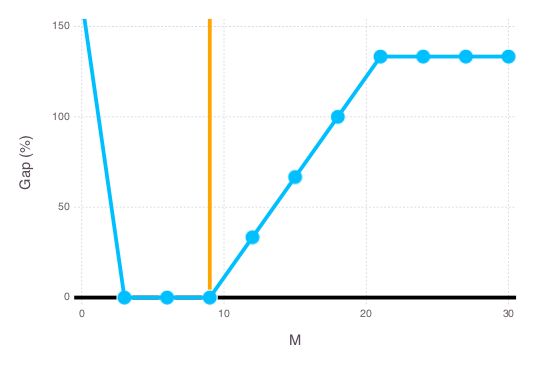

In [117]:
function example1(M)
    mod = Model(solver=GurobiSolver(OutputFlag=0))
    @defVar(mod, x[1:3] ≥ 0)
    @defVar(mod, z[1:3], Bin)
    @setObjective(mod, Max, sum(x))
    
    # We will make our Ax≤b a very simple set!
    @addConstraint(mod, x[1] ≤ 4)
    @addConstraint(mod, x[2] ≤ 8)
    @addConstraint(mod, x[3] ≤ 9)
    
    @addConstraint(mod, bigm[i=1:3], x[i] ≤ M*z[i])
    @addConstraint(mod, sum(z) ≤ 1)
    
    solve(mod, relaxation=true)
    relax = getObjectiveValue(mod)
    
    solve(mod)
    opt = getObjectiveValue(mod)
    
    # MILP objective is 9, compare with LP objective
    gap = (relax-opt) / opt
#     gap = (getObjectiveValue(mod) - 9)/9

    return 100gap, getValue(x)[:], getValue(z)[:]
end

Mrange = 0:3:30
plot(
    x=Mrange,y=[example1(M)[1] for M in Mrange],
    Geom.line,Geom.point,
    xintercept=[9], Geom.vline(color="orange"),
    yintercept=[0], Geom.hline(color="black"),
    Guide.xlabel("M"),
    Guide.ylabel("Gap (%)"),
    Theme(line_width=1mm, default_point_size=2mm),
)

### Presolve to the rescue?

Presolve can sometimes infer these bounds on continous variables, and will tighten our big Ms. The ability for the solver to inference depends on how complicated your constraints are.

In [120]:
function example2(M,presolve)
    mod = Model(solver=GurobiSolver(Cuts=0,Heuristics=0,Presolve=presolve))
    @defVar(mod, x[1:3] ≥ 0)
    @defVar(mod, z[1:3], Bin)
    @setObjective(mod, Max, sum(x))
    
    # We will make our Ax≤b a very simple set!
    @addConstraint(mod, x[1] ≤ 4)
    @addConstraint(mod, x[2] ≤ 8)
    @addConstraint(mod, x[3] ≤ 9)
    
    @addConstraint(mod, bigm[i=1:3], x[i] ≤ M*z[i])
    @addConstraint(mod, sum(z) ≤ 1)
    
    solve(mod)
end
println("WITHOUT PRESOLVE")
example2(100,0)
println("\n\nWITH PRESOLVE")
example2(100,1)

WITHOUT PRESOLVE


:Optimal

Optimize a model with 7 rows, 6 columns and 12 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+02]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [1e+00, 9e+00]
Variable types: 3 continuous, 3 integer (3 binary)

Root relaxation: objective 2.100000e+01, 3 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   21.00000    0    3          -   21.00000      -     -    0s
     0     0   21.00000    0    3          -   21.00000      -     -    0s
     0     2   21.00000    0    3          -   21.00000      -     -    0s
*    2     2               2       4.0000000    9.00000   125%   0.0    0s
*    3     1               1       9.0000000    9.00000  0.00%   0.3    0s

Explored 4 nodes (8 simplex iterations) in 0.00 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.

## Piecewise constant functions

> Lots more to learn about this in [Juan Pablo's review](http://www.mit.edu/~jvielma/publications/index.html#Mixed-Integer-Linear-Programming-Formulation-Techniques) of formulation techniques!

In this section we are going to try to model the following type of relationship:

$$
z(x) = \begin{cases}
a_{1} & \quad r_{1}\leq x\leq r_{2}\\
a_{2} & \quad r_{2}\leq x\leq r_{3}\\
\vdots\\
a_{n-1} & \quad r_{n-1}\leq x\leq r_{n}
\end{cases}
$$

where $z$ is a piecewise constant function of the variable $x$. Lets create an auxiliary binary variable

$$ x \geq r_i \Longrightarrow y_i = 1 $$

which we can do with linear inequalities

\begin{alignat*}{2}
    y_i &\geq   &(x - r_{i})/M \\
    y_i &\leq 1-&(x - r_{i})/M
\end{alignat*}

Lets then define

$$ \delta_i = a_i - a_{i-1} $$

where $a_{0}=0$. Then we can say that

$$ z = \sum_{i=1}^{n-1} \delta_i y_i $$

Lets check it out for real data:

[3

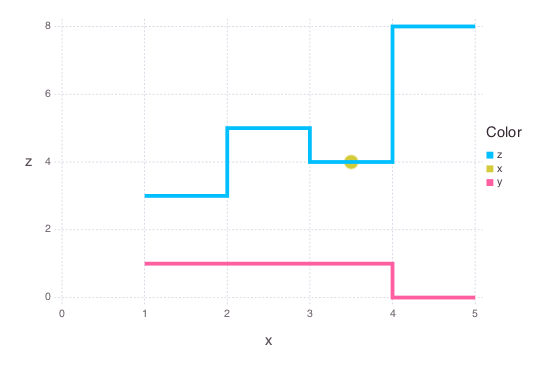

,2,-1,4]


In [131]:
n = 4
a = [3, 5, 4, 8]
r = [1, 2, 3, 4, 5]
M = 10

function piecewise_const()
    m = Model(solver=GurobiSolver(OutputFlag=0))
    @defVar(m, z)
    @defVar(m, x == 3.5) # Fixed variable
    @defVar(m, y[i=1:n], Bin)
    
    # Calculate delta
    δ = [a[1]]
    for i in 2:n
        push!(δ, a[i] - a[i-1])
    end
    println(δ)
    
    # Connect y to x
    for i in 1:n
        @addConstraint(m, y[i] ≥     (x - r[i])/M)
        @addConstraint(m, y[i] ≤ 1 + (x - r[i])/M)
    end
    
    # Connect y to z
    @addConstraint(m, z == dot(δ,y))
    
    # Solve for z and y
    solve(m)
    
    getValue(z)
    getValue(y)
end
piecewise_const()
plot(
layer(x=[1,2,2,3,3,4,4,5], y=[3,3,5,5,4,4,8,8],color=fill("z",8),Geom.line),
layer(x=[3.5],y=[4.0],Geom.point,color=["x"]),
layer(x=[1,4,4,5],y=[1,1,0,0],Geom.line,color=fill("y",4)),
Scale.y_continuous(minvalue=0),
Guide.ylabel("z"),
Guide.xlabel("x"),
Theme(line_width=1mm, default_point_size=2mm),
)

So why does this work? Lets look at a plot of those constraints on $y_3$:

Interact.Slider{Float64}(Signal{Float64}(5.0, nactions=0),"M",5.0,0.0:0.1:10.0,true)

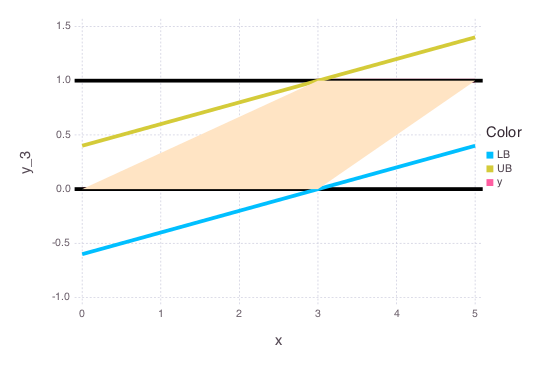

In [138]:
@manipulate for M in 0:0.1:10.0
    xvals  = 0:0.1:5.0
    lbvals =     (xvals - 3.0)/M
    ubvals = 1 + (xvals - 3.0)/M
    plot(
    layer(x=xvals,y=lbvals,Geom.line,color=fill("LB",length(xvals))),
    layer(x=xvals,y=ubvals,Geom.line,color=fill("UB",length(xvals))),
        Guide.annotation(
        compose(context(), polygon([(0,0),(3,1), (5,1), (3,0)]),fill("bisque"))),
    layer(yintercept=[0.0,1.0],Geom.hline(color="black")),
    layer(x=[0,3,3,5],y=[0,0,1,1],Geom.line,color=fill("y",4)),
    Guide.ylabel("y_3"),
    Guide.xlabel("x"),
    Theme(line_width=1mm, default_point_size=2mm),
    )
end

## Unions of polyhedra

The piecewise linear modeling above can be seen as a special case of a more general modeling paradigm:

$$
\begin{align*}
\min_{x}\quad& c^Tx \\
\text{s.t.}\quad& x \in \bigcup_{i=1}^m P_i
\end{align*}
$$

where $P_i = \{x : A^i x \leq b^i\}$ are polyhedra. We'll assume for today that they are bounded (i.e. polytopes); for a more general treatment, take 15.083J.

How do we formulate this?

### 2) Big-Ms

Before we saw that if we take some $M$ constant value sufficiently large, we can switch on and off linear constraints using binary variables.

$$
\begin{align*}
    \min_{x,z}\quad& c^Tx \\
    \text{s.t.}\quad& A^ix \leq b^i + M(1-z_i) \quad \forall i = 1,\ldots,m \\
    & \sum_{i=1}^m z_i = 1 \\
    & x \in \mathbb{R}^n \\
    & z \in \{0,1\}^m.
\end{align*}
$$

### 1) Balas extended formulation
Big-$M$s can be weak, either inherently or because you don't have particularly tight values. Fortunately, we can construct the _strongest possible_ formulation by adding some auxiliary variables.

$$
\begin{align*}
    \min_{x,x^1,\ldots,x^m,z}\quad& c^Tx \\
    \text{s.t.}\quad& A^ix^i \leq b^iz_i \quad \forall i = 1,\ldots,m \\
    & \sum_{i=1}^m z_i = 1 \\
    & x = \sum_{i=1}^m x^i \\
    & x^i \in \mathbb{R}^n \quad \forall i = 1,\ldots,m \\
    & z \in \{0,1\}^m.
\end{align*}
$$

## Example: Collision avoidance
Imagine you're a pilot on the front lines of an imaginary conflict region. To avoid escalation, you absolutely _cannot_ enter a certain airspace. However, as a show of force, you would like to get as close as possible to an enemy encampment. How can we model this with MIP?

Interact.Slider{Int64}(Signal{Int64}(3, nactions=0),"region",3,1:6,true)

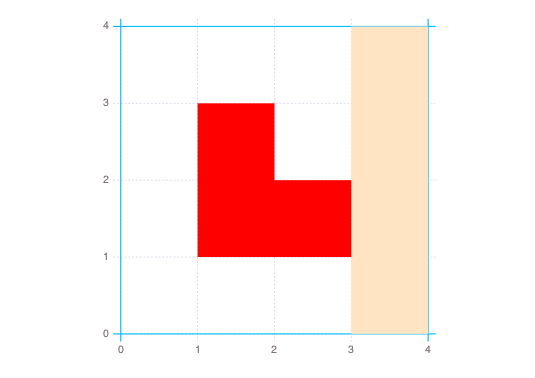

In [83]:
L, U = 0, 3

regions = ([(0,0)],
           [(0,0), (4,0), (4,1), (0,1)],
           [(3,0), (4,0), (4,4), (3,4)],
           [(2,2), (4,2), (4,4), (2,4)],
           [(0,3), (4,3), (4,4), (0,4)],
           [(0,0), (1,0), (1,4), (0,4)])

@manipulate for region in 1:6
    plot(
        layer(xintercept=[0], Geom.vline()),
        layer(xintercept=[4], Geom.vline()),
        layer(yintercept=[0], Geom.hline()),
        layer(yintercept=[4], Geom.hline()),
        Guide.annotation(
            compose(context(), polygon([(1,1),(3,1), (3,2), (2,2), (2,3), (1,3)]),fill("red"))),
        Guide.annotation(
    compose(context(), polygon(regions[region]),fill("bisque"))),
        Coord.cartesian(fixed=true)
    )
end

Interact.Slider{Int64}(Signal{Int64}(3, nactions=0),"ii",3,1:5,true)

Optimize a model with 11 rows, 9 columns and 25 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 3e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 3e+00]
  RHS range       [1e+00, 4e+00]
Found heuristic solution: objective 3.7
Presolve time: 0.00s
Presolved: 11 rows, 9 columns, 35 nonzeros
Variable types: 4 continuous, 5 integer (5 binary)

Root relaxation: objective 3.000000e-01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.3000000    0.30000  0.00%     -    0s

Explored 0 nodes (6 simplex iterations) in 0.00 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e-01, best bound 3.000000000000e-01, gap 0.0%


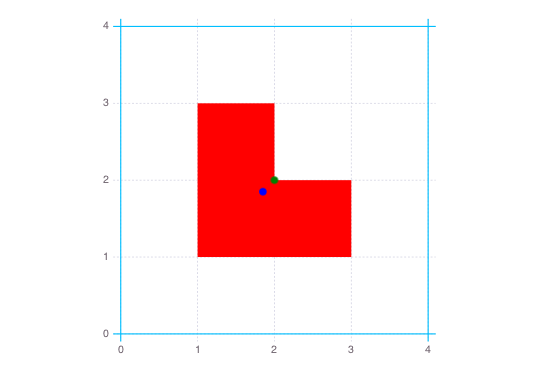

In [142]:
const M = 3

x̂ = [1.35, 2.75, 1.85, 1.45, 1.15]
ŷ = [1.1,  1.5,  1.85, 2.85, 2.25]

nregion = 5

@manipulate for ii in 1:nregion
    model = Model(solver=GurobiSolver())

    @defVar(model, L ≤ x ≤ U)
    @defVar(model, L ≤ y ≤ U)

    @defVar(model, z[1:nregion], Bin)

    @addConstraints(model, begin
        y ≤ 1 + M*(1-z[1])

        x ≥ 3 - M*(1-z[2])

        x ≥ 2 - M*(1-z[3])
        y ≥ 2 - M*(1-z[3])

        y ≥ 3 - M*(1-z[4])

        x ≤ 1 + M*(1-z[5])

        sum(z) == 1
    end)

    # Add an objective that will try to pull us into the center
    @defVar(model, dˣ ≥ 0)
    @defVar(model, dʸ ≥ 0)

    @addConstraints(model, begin
        dˣ ≥ x - x̂[ii]
        dˣ ≥ x̂[ii] - x
        dʸ ≥ y - ŷ[ii]
        dʸ ≥ ŷ[ii] - y
    end)
    @setObjective(model, Min, dˣ + dʸ)
    solve(model)

    plot(
        layer(xintercept=[0], Geom.vline()),
        layer(xintercept=[4], Geom.vline()),
        layer(yintercept=[0], Geom.hline()),
        layer(yintercept=[4], Geom.hline()),
        Guide.annotation(
            compose(context(), circle([x̂[ii]], [ŷ[ii]], [1mm]), fill("blue"))),
        Guide.annotation(
            compose(context(), circle([getValue(x)], [getValue(y)], [1mm]), fill("green"))),
        Guide.annotation(
            compose(context(), polygon([(1,1),(3,1), (3,2), (2,2), (2,3), (1,3)]),fill("red"))),
        Coord.cartesian(fixed=true)
    )
end

Interact.Slider{Int64}(Signal{Int64}(3, nactions=0),"ii",3,1:5,true)

Optimize a model with 33 rows, 19 columns and 67 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 3e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 3e+00]
  RHS range       [1e+00, 2e+00]
Found heuristic solution: objective 3.7
Presolve removed 16 rows and 2 columns
Presolve time: 0.00s
Presolved: 17 rows, 17 columns, 51 nonzeros
Variable types: 12 continuous, 5 integer (5 binary)

Root relaxation: objective 3.000000e-01, 9 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.3000000    0.30000  0.00%     -    0s

Explored 0 nodes (9 simplex iterations) in 0.00 seconds
Thread count was 2 (of 4 available processors)

Optimal solution found (tolerance 1.00e-04)
Best objective 3.000000000000e-01, best bound 3.000000000000e-01, gap 0.0%


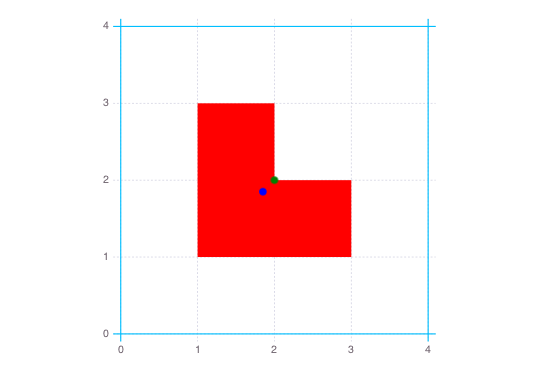

In [141]:
@manipulate for ii in 1:nregion
    model = Model(solver=GurobiSolver())

    @defVar(model, L ≤ x ≤ U)
    @defVar(model, L ≤ y ≤ U)
    
    @defVar(model, xx[1:nregion])
    @defVar(model, yy[1:nregion])

    @defVar(model, z[1:nregion], Bin)

    @addConstraints(model, begin
        yy[1] ≤ 1z[1]

        xx[2] ≥ 3z[2]

        xx[3] ≥ 2z[3]
        yy[3] ≥ 2z[3]

        yy[4] ≥ 3z[4]

        xx[5] ≤ 1z[5]

        x == sum(xx)
        y == sum(yy)
        
        sum(z) == 1
    end)
    
    # Don't forget the variable bounds!!
    for i in 1:nregion
        @addConstraints(model, begin
            xx[i] ≥ L*z[i]
            yy[i] ≥ L*z[i]
            xx[i] ≤ U*z[i]
            yy[i] ≤ U*z[i]
        end)
    end

    # Add an objective that will try to pull us into the center
    @defVar(model, dˣ ≥ 0)
    @defVar(model, dʸ ≥ 0)

    @addConstraints(model, begin
        dˣ ≥ x - x̂[ii]
        dˣ ≥ x̂[ii] - x
        dʸ ≥ y - ŷ[ii]
        dʸ ≥ ŷ[ii] - y
    end)
    @setObjective(model, Min, dˣ + dʸ)
    solve(model)
    
    plot(
        layer(xintercept=[0], Geom.vline()),
        layer(xintercept=[4], Geom.vline()),
        layer(yintercept=[0], Geom.hline()),
        layer(yintercept=[4], Geom.hline()),
        Guide.annotation(
            compose(context(), circle([x̂[ii]], [ŷ[ii]], [1mm]), fill("blue"))),
        Guide.annotation(
            compose(context(), circle([getValue(x)], [getValue(y)], [1mm]), fill("green"))),
        Guide.annotation(
            compose(context(), polygon([(1,1),(3,1), (3,2), (2,2), (2,3), (1,3)]),fill("red"))),
        Coord.cartesian(fixed=true)
    )
end

### Solution to XOR question

$$
z \geq x - y \\
z \geq y - x \\
z \leq x + y \\
z \leq 2 - x - y
$$

Check

* $x=0,y=0$ - third constraint implies $z \leq 0$
* $x=1,y=0$ - first constraint implies $z \geq 1$
* $x=0,y=1$ - second constraint implies $z \geq 1$
* $x=1,y=1$ - fourth constraint implies $z \leq 2-1-1 = 0$

### Solution to presolve question

* $6x_1 + 10x_2 + 12x_3 + 19x_4 \leq 15$
* $x_4$ must be 0, because if $x_4$ was 1 then the constaint would be violated
* $6x_1 + 10x_2 + 12x_3 \leq 15$
* All coefficients on left are multiples of 2, so divide through by 2
* $3x_1 + 5x_2 + 6x_3 \leq 7.5$
* All coefficients are integer, all variables are binary, so can round down the RHS.
* $3x_1 + 5x_2 + 6x_3 \leq 7$
* We note though that only one of these variables can be one at a time, or the constraint would be violated, so the best we can do is actually
* $x_1 + x_2 + x_3 \leq 1$

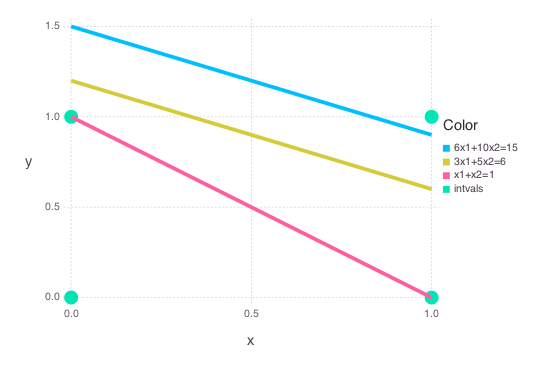

In [55]:
xvals = 0:0.1:1.0
plot(
layer(x=xvals, y=(15 - 6xvals)/10, color=fill("6x1+10x2=15",length(xvals)), Geom.line),
layer(x=xvals, y=( 6 - 3xvals)/5,  color=fill("3x1+5x2=6",  length(xvals)), Geom.line),
layer(x=xvals, y=( 1 -  xvals),    color=fill("x1+x2=1",    length(xvals)), Geom.line),
layer(x=[0,0,1,1], y=[0,1,0,1],    color=fill("intvals",    4),             Geom.point),
Theme(line_width=1mm, default_point_size=2mm),
)